In [1]:
from run import build

import torch
import matplotlib.pyplot as plt


In [2]:
pssm, ds_test = build(
    load_encoder_path="./networks/encoder.ckpt",
    load_decoder_path="./networks/decoder_net_dataset_100_10_8000_100.ckpt",
    load_decoder_dataset_path="./data/Datasets/decoder/decoder_dataset_100_5_1000_100.pt"
)

pssm.encoder.to('cpu')
pssm.decoder.to('cpu')

Generating encoder dataset... Done.
Loading encoder from checkpoint... 1
Done.
Loading decoder from checkpoint... Done.
Creating PoissonSSM model... Done.


MLP(
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
)

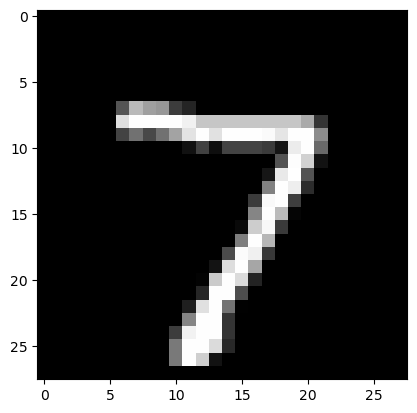

In [3]:
img = ds_test[0][0]

plt.imshow(img.reshape(28, 28), cmap='gray')

In [ ]:
from tqdm.notebook import trange
import numpy as np
import seaborn as sns

mean_rts, mean_accuracies = [], []

n_tests = 1000
for i in trange(n_tests):
    img, label = ds_test[i]
    rts, action, entropies = pssm.get_rts(img, threshold=.75, n_repeats=100, plot_results=False)

    mean_accuracies.append((action == label).float().mean())
    mean_rts.append(np.mean(rts))

mean_accuracies = np.array(mean_accuracies)
mean_rts = np.array(mean_rts)

  0%|          | 0/1000 [00:00<?, ?it/s]

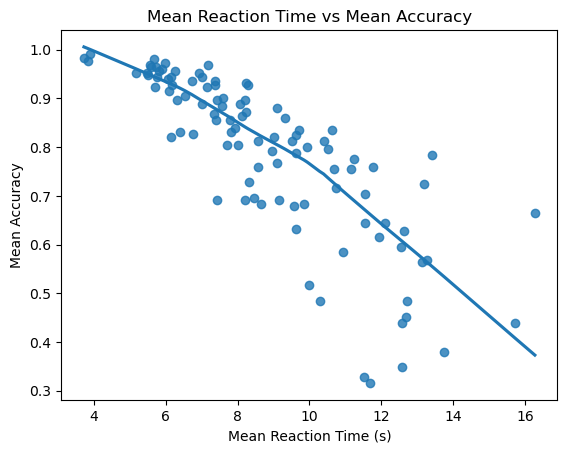

In [ ]:
# regression plot for mean_rts vs mean_accuracies
sns.regplot(x=mean_rts, y=mean_accuracies, lowess=True, color='slategray', line_kws={'color': 'slategrey'})
plt.xlabel('Mean Reaction Time (s)')
plt.ylabel('Mean Accuracy')
plt.title('Mean Reaction Time vs Mean Accuracy')
plt.show()

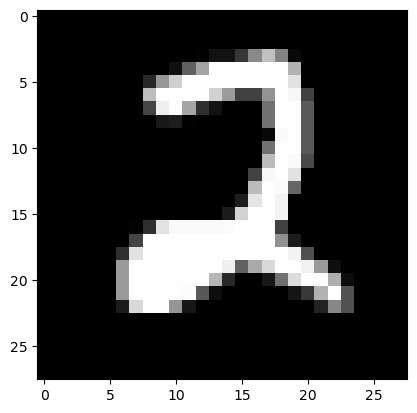

In [ ]:
# get index with min accuracy
min_accuracy_index = np.argmin(mean_accuracies)
# get image
min_img, min_label = ds_test[min_accuracy_index]
plt.imshow(img.reshape(28, 28), cmap='gray')

In [ ]:
# get index with min accuracy
max_accuracy_index = np.argmax(mean_accuracies)
# get image
max_img, max_label = ds_test[min_accuracy_index]
plt.imshow(img.reshape(28, 28), cmap='gray')

In [ ]:
min_rts, min_actions, min_entropies = pssm.get_rts(img, threshold=.75, n_repeats=1000, plot_results=False)
max_rts, max_actions, max_entropies = pssm.get_rts(img, threshold=.75, n_repeats=1000, plot_results=False)

In [ ]:
threshold = 0.75

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].hist(min_rts, bins=30, color='slategray', alpha=0.5)
axs[0].hist(max_rts, bins=30, color='red', alpha=0.5)
axs[0].set_title("Time Index Distribution")

axs[1].hist(min_actions, bins=30, color='slategray', alpha=0.5)
axs[1].hist(max_actions, bins=30, color='red', alpha=0.5)
axs[1].set_title("Action Index Distribution")
axs[1].set_xticks(np.arange(10))


axs[2].set_title("Entropy Distribution")
for i in range(min(len(min_entropies), 100)):
    axs[2].plot(np.arange(len(min_entropies[i])), min_entropies[i], color='slategray', alpha=0.02)
    axs[2].plot(np.arange(len(max_entropies[i])), max_entropies[i], color='red', alpha=0.02)

axs[2].plot(np.arange(len(min_entropies[0])), np.mean(min_entropies, axis=0), color='slategray', linewidth=2, label='Mean Entropy (Easy)')
axs[2].plot(np.arange(len(max_entropies[0])), np.mean(max_entropies, axis=0), color='red', linewidth=2, label='Mean Entropy (Hard)')
# plot line at threshold
axs[2].axhline(y=threshold, color='black', linestyle='--', label='Threshold', linewidth=.7, alpha=0.7)
axs[2].legend()

plt.tight_layout()
plt.show()

In [5]:
from run import evaluate

evaluate(pssm, ds_test, n_eval=20)

running evaluation...


  0%|          | 0/250 [00:00<?, ?it/s]

 36%|███▌      | 90/250 [00:01<00:01, 84.58it/s]


IndexError: index 0 is out of bounds for axis 0 with size 0

  0%|          | 0/5 [00:00<?, ?it/s]

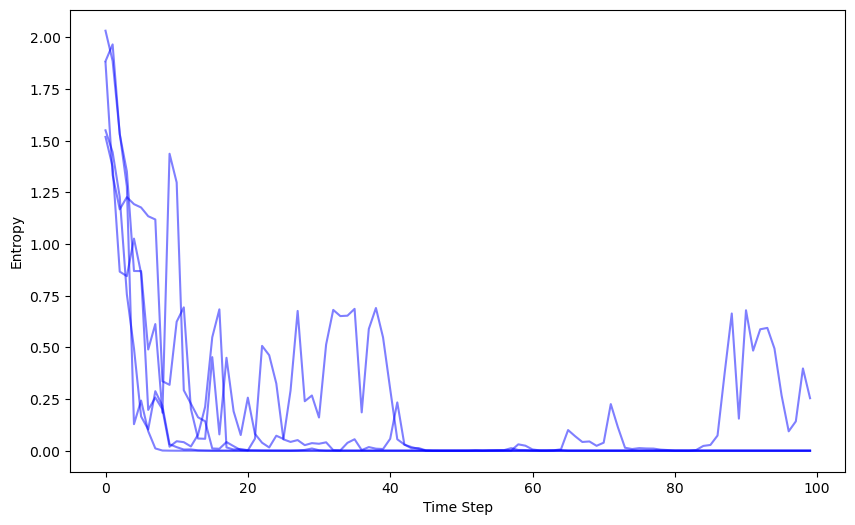

In [38]:

from tqdm.notebook import tqdm
import numpy as np
from scipy.stats import entropy
import torch.nn as nn
from pssm.utils import cumulative_spike_matrix

threshold = .25
rts = []
fig, ax = plt.subplots(figsize=(10, 6))
for img in tqdm(ds_test[:5]):

    device = 'cpu'
    n_timesteps = 100
    encoder.eval().to(device)
    decoder.eval().to(device)

    dist, _, _, _ = encoder.forward(img.unsqueeze(0).unsqueeze(0).to(device))
    # encode the image into latent space
    # sample spikes train
    sample, indicator, times = dist.rsample(hard=True, return_indicator=True)
    # convert to cumulative spike matrix
    cumulative_matrix = cumulative_spike_matrix(indicator, times, n_steps=n_timesteps)

    #print("Cumulative matrix shape:", cumulative_matrix.shape)

    logits = [decoder(x.float().to(device)) for x in cumulative_matrix.T]
    probs = [nn.functional.softmax(logit, dim=-1) for logit in logits]
    entropies = [entropy(prob.detach().cpu().numpy()) for prob in probs]

    rts.append(np.where(np.array(entropies) < threshold)[0][0].item())


    ax.plot(torch.arange(100), entropies, label='Entropy', color='blue', alpha=0.5)

ax.set_xlabel('Time Step')
ax.set_ylabel('Entropy')

plt.show()


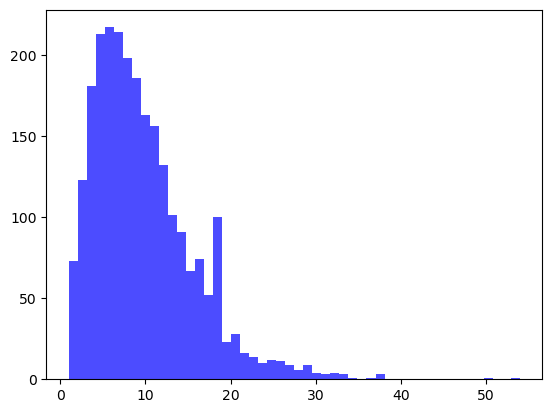

In [37]:
#plot histogram of rts
plt.hist(rts, bins=50, color='blue', alpha=0.7)

plt.show()